## Loading data into dataframe for ease of access

In [3]:
import numpy as np
import pandas as pd
import os
import time 
import glob
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
os.listdir('BBC News Summary/Summaries')

['entertainment', 'business', 'sport', 'politics', 'tech']

In [5]:
articles_path = 'BBC News Summary/News Articles'
summaries_path = 'BBC News Summary/Summaries'
categories_list = ['politics', 'sport', 'tech', 'entertainment', 'business']

In [6]:
def read_files_from_folders(articles_path, summaries_path, categories_list=['tech', 'sport'], encoding = "ISO-8859-1"):
    articles = []
    summaries = []
    categories = []
    for category in categories_list:
        article_paths = glob.glob(os.path.join(articles_path, category, '*.txt'), recursive=True)
        summary_paths = glob.glob(os.path.join(summaries_path, category, '*.txt'), recursive=True)
        
        if len(article_paths) != len(summary_paths):
            print('number of files is not equal')
            return
        for i in range(len(article_paths)):
            categories.append(category)
            with open(article_paths[i], mode='r', encoding = encoding) as file:
                articles.append(file.read())
            
            with open(summary_paths[i], mode='r', encoding = encoding) as file:
                summaries.append(file.read())
    return articles, summaries, categories

In [7]:
articles, summaries, categories = read_files_from_folders(articles_path, summaries_path, categories_list)

In [8]:
df = pd.DataFrame({'articles':articles, 'summaries':summaries, 'categories':categories})

In [9]:
df

,articles,summaries,categories
0,Baron Kinnock makes Lords debut\n\nFormer Labo...,Former Labour leader Neil Kinnock has official...,politics
1,Howard taunts Blair over splits\n\nTony Blair'...,It claims Mr Blair said in November 2003 he wo...,politics
2,Donor attacks Blair-Brown 'feud'\n\nThe report...,"Mr Bannatyne has previously given Labour Â£50,...",politics
3,Cardinal criticises Iraq war cost\n\nBillions ...,"""How is it that peace has not arrived?,"" the c...",politics
4,BNP leader Nick Griffin arrested\n\nThe leader...,Mr Griffin is the twelfth man to be arrested f...,politics
...,...,...,...
2220,Jobs growth still slow in the US\n\nThe US cre...,The job gains mean that President Bush can cel...,business
2221,Renault boss hails 'great year'\n\nStrong sale...,Strong sales outside western Europe helped Ren...,business
2222,Euro firms miss out on optimism\n\nMore than 9...,"Possibly as a result, the worry about low-cost...",business
2223,Bank holds interest rate at 4.75%\n\nThe Bank ...,CBI chief economist Ian McCafferty said the ec...,business


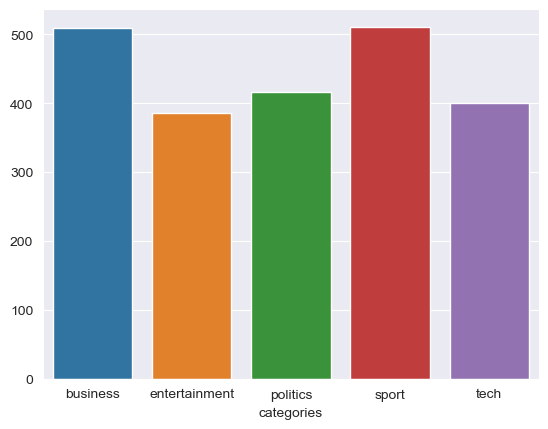

In [10]:
category_sizes = df.groupby('categories').size()
sns.barplot(x=category_sizes.index, y=category_sizes)
plt.show()

In [11]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/zijieli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
df['summaries']

0       Former Labour leader Neil Kinnock has official...
1       It claims Mr Blair said in November 2003 he wo...
2       Mr Bannatyne has previously given Labour Â£50,...
3       "How is it that peace has not arrived?," the c...
4       Mr Griffin is the twelfth man to be arrested f...
                              ...                        
2220    The job gains mean that President Bush can cel...
2221    Strong sales outside western Europe helped Ren...
2222    Possibly as a result, the worry about low-cost...
2223    CBI chief economist Ian McCafferty said the ec...
2224    Blackwatch's Baghdad-based affiliate Falcon Gr...
Name: summaries, Length: 2225, dtype: object

In [13]:
tokenized_texts = []

for summary in df['articles']:
    sentences = sent_tokenize(summary)
    for sentence in sentences:
        tokenized_texts.append(word_tokenize(sentence))

for summary in df['summaries']:
    sentences = sent_tokenize(summary)
    for sentence in sentences:
        tokenized_texts.append(word_tokenize(sentence))
    
len(tokenized_texts)

46048

In [14]:
from gensim.models import Word2Vec

# Train a Word2Vec model
model = Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=3, workers=4)

In [15]:
# Get the vector for a specific word
word_vector = model.wv.most_similar('children', topn=10)

print(word_vector)

[('players', 0.8660340905189514), ('teams', 0.8028277158737183), ('fans', 0.7993184328079224), ('parents', 0.7985693216323853), ('women', 0.7898350358009338), ('customers', 0.7833248376846313), ('clubs', 0.7799148559570312), ('parties', 0.7789074778556824), ('different', 0.772015392780304), ('phones', 0.7701560854911804)]


In [16]:
from sklearn.decomposition import PCA
rawWordVec =[]
word2ind = {}

for i, w in enumerate(model.wv.index_to_key):
    rawWordVec.append(model.wv[w])
    word2ind[w] = i
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

In [17]:
X_reduced.shape

(20687, 2)

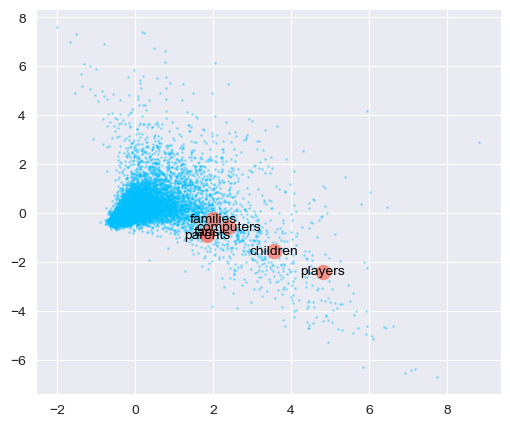

In [18]:
fig = plt.figure(figsize = (6, 5))
ax = fig.gca()
ax.plot(X_reduced[:,0], X_reduced[:,1], 'o', color='deepskyblue', alpha = 0.3, markersize=1)

words = ['children', 'parents', 'fans', 'families', 'computers', 'players']
for w in words:
    if w in word2ind:
        ind = word2ind[w]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], 'o', color='salmon', alpha = 0.8, markersize = 10)
        plt.text(xy[0], xy[1], w, ha='center', va='center', color='k')
        